## 1. Setup and Imports

In [41]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from typing import Dict
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ Imports successful")

✅ Imports successful


## 2. Load V2 Benchmark Data

In [42]:
def load_benchmarkv2_files(benchmark_dir: Path) -> Dict[str, Dict]:
    """Load only the latest V2 benchmark JSON file per model."""
    benchmarks = {}
    model_files = {}
    
    # First pass: collect all V2 files per model
    for json_file in benchmark_dir.glob("*benchmarkv2*.json"):
        with open(json_file, 'r') as f:
            data = json.load(f)
            model_name = data['model']
            
            # Extract timestamp from filename
            filename = json_file.name
            timestamp_str = filename.split('_')[0] + '_' + filename.split('_')[1]
            
            if model_name not in model_files:
                model_files[model_name] = []
            model_files[model_name].append((timestamp_str, json_file, data))
    
    # Second pass: keep only the latest file per model
    for model_name, files in model_files.items():
        files.sort(key=lambda x: x[0], reverse=True)
        latest_file = files[0]
        
        benchmarks[model_name] = latest_file[2]
        print(f"  📅 {model_name}: Using {latest_file[1].name}")
    
    return benchmarks

# Load all V2 benchmarks
benchmark_dir = Path("benchmarks")
all_benchmarks = load_benchmarkv2_files(benchmark_dir)

print(f"\n📊 Loaded V2 benchmarks for {len(all_benchmarks)} models")
for model, data in all_benchmarks.items():
    print(f"  - {model}: {len(data['samples'])} samples")

  📅 amazon/chronos-2: Using 20251208_185443_benchmarkv2_amazon_chronos-2.json
  📅 NX-AI/TiRex: Using 20251208_190803_benchmarkv2_NX-AI_TiRex.json
  📅 google/timesfm-2.5-200m-pytorch: Using 20251208_193556_benchmarkv2_google_timesfm-2.5-200m-pytorch.json
  📅 amazon/chronos-bolt-tiny: Using 20251212_121400_benchmarkv2_amazon_chronos-bolt-tiny.json

📊 Loaded V2 benchmarks for 4 models
  - amazon/chronos-2: 6020 samples
  - NX-AI/TiRex: 6020 samples
  - google/timesfm-2.5-200m-pytorch: 6020 samples
  - amazon/chronos-bolt-tiny: 6020 samples


## 3. Denormalization and Metric Calculation

In [43]:
def denormalize_prediction(normalized_pred: np.ndarray, mean: float, std: float) -> np.ndarray:
    """Denormalize predictions using stored mean and std."""
    return normalized_pred * std + mean

def calculate_metrics(pred: np.ndarray, target: np.ndarray, context: np.ndarray) -> Dict:
    """Calculate all forecasting metrics."""
    # MAE
    mae = np.mean(np.abs(pred - target))
    
    # RMSE
    rmse = np.sqrt(np.mean((pred - target) ** 2))
    
    # NRMSE
    target_range = np.max(target) - np.min(target)
    nrmse = rmse / target_range if target_range > 0 else float('inf')
    
    # ND (Normalized Deviation)
    nd = np.sum(np.abs(pred - target)) / np.sum(np.abs(target)) if np.sum(np.abs(target)) > 0 else float('inf')
    
    # MAPE
    epsilon = 1e-8
    mape = 100.0 * np.mean(np.abs((pred - target) / (np.abs(target) + epsilon)))
    
    # sMAPE
    smape = 100.0 * np.mean(2.0 * np.abs(pred - target) / (np.abs(pred) + np.abs(target) + epsilon))
    
    # MASE
    naive_forecast_error = np.mean(np.abs(np.diff(target)))
    mase = mae / naive_forecast_error if naive_forecast_error > 0 else float('inf')
    
    # Directional Accuracy
    pred_direction = np.sign(np.diff(pred))
    target_direction = np.sign(np.diff(target))
    directional_acc = 100.0 * np.mean(pred_direction == target_direction)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'NRMSE': nrmse,
        'ND': nd,
        'MAPE': mape,
        'sMAPE': smape,
        'MASE': mase,
        'Directional Accuracy': directional_acc
    }

print("✅ Denormalization and metric functions defined")

✅ Denormalization and metric functions defined


## 4. Process All Samples and Calculate Metrics

In [44]:
def process_benchmarkv2_data(benchmarks: Dict[str, Dict]) -> pd.DataFrame:
    """Process V2 benchmark data and calculate metrics for each sample."""
    rows = []
    
    for model_name, benchmark_data in benchmarks.items():
        for sample in benchmark_data['samples']:
            sample_id = sample['sample_id']
            context = np.array(sample['context'])
            target = np.array(sample['target'])
            pred_quantiles_norm = np.array(sample['prediction_quantiles'])  # [n_quantiles, pred_len]
            mean = sample['normalization_mean']
            std = sample['normalization_std']
            
            # Denormalize predictions
            pred_quantiles = denormalize_prediction(pred_quantiles_norm, mean, std)
            
            # Extract median prediction (middle quantile)
            n_quantiles = pred_quantiles.shape[0]
            median_pred = pred_quantiles[n_quantiles // 2, :]
            
            # Calculate metrics
            metrics = calculate_metrics(median_pred, target, context)
            
            # Store everything
            row = {
                'model': model_name,
                'sample_id': sample_id,
                'context': context,
                'target': target,
                'prediction': median_pred,
                'pred_quantiles': pred_quantiles,
                'mean': mean,
                'std': std,
                **metrics
            }
            rows.append(row)
    
    return pd.DataFrame(rows)

# Process all data
df = process_benchmarkv2_data(all_benchmarks)

print(f"📈 Processed {len(df)} samples across all models")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {[col for col in df.columns if col not in ['context', 'target', 'prediction', 'pred_quantiles']]}")
df[[col for col in df.columns if col not in ['context', 'target', 'prediction', 'pred_quantiles']]].head()

📈 Processed 24080 samples across all models

Dataset shape: (24080, 16)

Columns: ['model', 'sample_id', 'mean', 'std', 'MAE', 'RMSE', 'NRMSE', 'ND', 'MAPE', 'sMAPE', 'MASE', 'Directional Accuracy']


,model,sample_id,mean,std,MAE,RMSE,NRMSE,ND,MAPE,sMAPE,MASE,Directional Accuracy
0,amazon/chronos-2,0,3.009247,3.263672,2.175287,2.864293,0.631452,0.188067,17.371353,20.250619,27.860855,28.571429
1,amazon/chronos-2,1,5.617352,3.928128,2.509307,3.239847,0.699328,0.177388,16.330344,18.854149,24.954037,38.095238
2,amazon/chronos-2,2,8.718957,3.368798,0.635820,0.780459,0.224186,0.039006,3.852397,3.863702,6.856784,53.968254
3,amazon/chronos-2,3,11.582230,3.061751,2.321204,2.555420,0.946908,0.133619,13.116515,14.241381,27.183402,34.920635
4,amazon/chronos-2,4,13.933628,2.633664,1.714022,2.024451,0.827015,0.094595,9.297872,9.936537,19.549812,44.444444


## 5. Summary Statistics

In [45]:
# Calculate summary statistics
metric_columns = ['MAE', 'RMSE', 'NRMSE', 'ND', 'MAPE', 'sMAPE', 'MASE', 'Directional Accuracy']

summary = df.groupby('model')[metric_columns].agg(['mean', 'std', 'median', 'min', 'max'])

print("📊 Summary Statistics by Model (V2 - Properly Denormalized)\n")
print("=" * 120)
summary

📊 Summary Statistics by Model (V2 - Properly Denormalized)



MAE                                     \
                                      mean        std    median           min   
model                                                                           
NX-AI/TiRex                      11.177976  12.138754  7.825832  4.461302e-17   
amazon/chronos-2                 11.575940  12.814947  7.826069  1.854232e-17   
amazon/chronos-bolt-tiny         12.495172  14.049523  8.525439  1.873918e-16   
google/timesfm-2.5-200m-pytorch  12.083631  13.127571  8.325248  0.000000e+00   

                                                  RMSE                        \
                                        max       mean        std     median   
model                                                                          
NX-AI/TiRex                      106.046929  13.193571  13.991781   9.480432   
amazon/chronos-2                  95.983489  13.670884  14.811442   9.523523   
amazon/chronos-bolt-tiny         167.607175  14.628393  16.049613  10.283263   
google/timesfm-2.5-200m-pytorch  118.982891  14.225591  15.080907  10.034799   

                                                           ... MASE      \
                                          min         max  ... mean std   
model                                                      ...            
NX-AI/TiRex                      5.362979e-17  111.530683  ...  inf NaN   
amazon/chronos-2                 2.411627e-17  112.891019  ...  inf NaN   
amazon/chronos-bolt-tiny         2.252983e-16  179.788356  ...  inf NaN   
google/timesfm-2.5-200m-pytorch  0.000000e+00  124.887019  ...  inf NaN   

                                                           \
                                    median       min  max   
model                                                       
NX-AI/TiRex                      10.729835  0.707654  inf   
amazon/chronos-2                 10.527109  0.528949  inf   
amazon/chronos-bolt-tiny         12.063788  1.724819  inf   
google/timesfm-2.5-200m-pytorch  11.078068  0.186958  inf   

                                Directional Accuracy                        \
                                                mean        std     median   
model                                                                        
NX-AI/TiRex                                54.116174  15.549149  52.380952   
amazon/chronos-2                           46.218162  13.700514  44.444444   
amazon/chronos-bolt-tiny                   46.489480  13.835708  44.444444   
google/timesfm-2.5-200m-pytorch            52.596636  13.709995  50.793651   

                                                       
                                      min         max  
model                                                  
NX-AI/TiRex                      0.000000  100.000000  
amazon/chronos-2                 0.000000  100.000000  
amazon/chronos-bolt-tiny         1.587302   95.238095  
google/timesfm-2.5-200m-pytorch  0.000000  100.000000  

[4 rows x 40 columns]

## 6. Plotting Utility Functions

In [39]:
def plot_sample_prediction(row, show_quantiles=True):
    """Plot a single sample's context, target, and prediction."""
    context = row['context']
    target = row['target']
    prediction = row['prediction']
    pred_quantiles = row['pred_quantiles']
    
    context_len = len(context)
    pred_len = len(prediction)
    
    context_x = range(context_len)
    future_x = range(context_len, context_len + pred_len)
    
    plt.figure(figsize=(14, 6))
    
    # Plot context
    plt.plot(context_x, context, label='Context', color='#4a90d9', linewidth=2)
    
    # Plot target
    plt.plot(future_x, target, label='Ground Truth', color='#2ecc71', linewidth=2, linestyle='--')
    
    # Plot median prediction
    plt.plot(future_x, prediction, label='Prediction (Median)', color='#e74c3c', linewidth=2, linestyle='-')
    
    # Plot quantiles if requested
    if show_quantiles and pred_quantiles is not None:
        n_quantiles = pred_quantiles.shape[0]
        lower_q = pred_quantiles[0, :]
        upper_q = pred_quantiles[-1, :]
        
        plt.fill_between(future_x, lower_q, upper_q, 
                        color='#e74c3c', alpha=0.2, 
                        label=f'Prediction Range ({n_quantiles} quantiles)')
    
    # Add metrics as text
    metrics_text = (
        f"MAE: {row['MAE']:.4f}  |  "
        f"RMSE: {row['RMSE']:.4f}  |  "
        f"MAPE: {row['MAPE']:.2f}%  |  "
        f"sMAPE: {row['sMAPE']:.2f}%  |  "
    )
    
    plt.title(f"Model: {row['model']} | Sample ID: {row['sample_id']}\n{metrics_text}", 
             fontsize=12, fontweight='bold')
    plt.xlabel('Time Step', fontsize=11)
    plt.ylabel('Value', fontsize=11)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✅ Plotting functions defined")

✅ Plotting functions defined


## 7. Identify Worst Predictions

In [40]:
# Find worst predictions by MAE for each model
print("🔴 Worst Predictions by MAE (Top 3 per model)\n")
print("=" * 80)

for model in df['model'].unique():
    model_data = df[df['model'] == model]
    worst_samples = model_data.nlargest(3, 'sMAPE')
    
    print(f"\n{model}:")
    print("-" * 80)
    for idx, row in worst_samples.iterrows():
        print(f"  Sample {row['sample_id']}: MAE={row['MAE']:.4f}, RMSE={row['RMSE']:.4f}, MAPE={row['MAPE']:.2f}% , sMAPE={row['sMAPE']:.2f}%")

🔴 Worst Predictions by MAE (Top 3 per model)


amazon/chronos-2:
--------------------------------------------------------------------------------
  Sample 1440: MAE=0.0000, RMSE=0.0000, MAPE=2123.35% , sMAPE=198.03%
  Sample 1980: MAE=0.0000, RMSE=0.0000, MAPE=2830.52% , sMAPE=194.38%
  Sample 320: MAE=0.0000, RMSE=0.0000, MAPE=11413.71% , sMAPE=193.79%

NX-AI/TiRex:
--------------------------------------------------------------------------------
  Sample 900: MAE=0.0000, RMSE=0.0000, MAPE=8033.95% , sMAPE=194.32%
  Sample 1560: MAE=0.0000, RMSE=0.0000, MAPE=3530.15% , sMAPE=191.85%
  Sample 1440: MAE=0.0000, RMSE=0.0000, MAPE=5242.19% , sMAPE=185.34%

google/timesfm-2.5-200m-pytorch:
--------------------------------------------------------------------------------
  Sample 1280: MAE=0.0007, RMSE=0.0008, MAPE=81407.11% , sMAPE=198.31%
  Sample 380: MAE=0.0005, RMSE=0.0006, MAPE=17417.77% , sMAPE=196.23%
  Sample 900: MAE=0.0000, RMSE=0.0000, MAPE=8751.08% , sMAPE=193.19%

amazon/chronos

## 8. Plot Worst Predictions

Plotting worst prediction for each model...



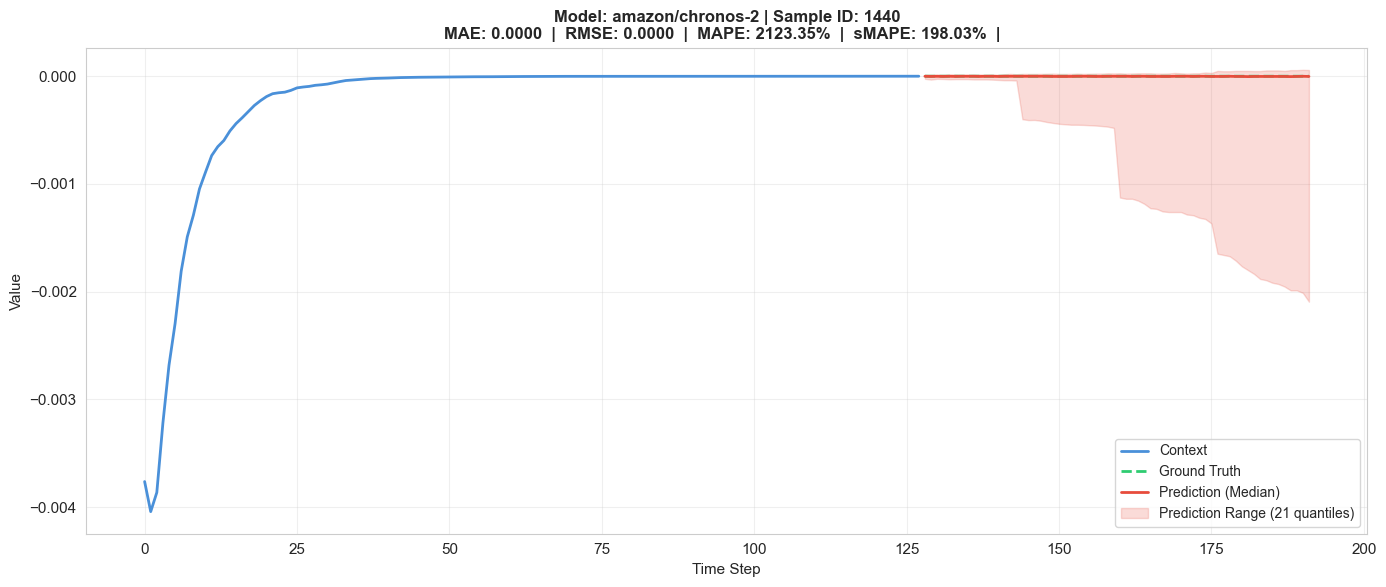

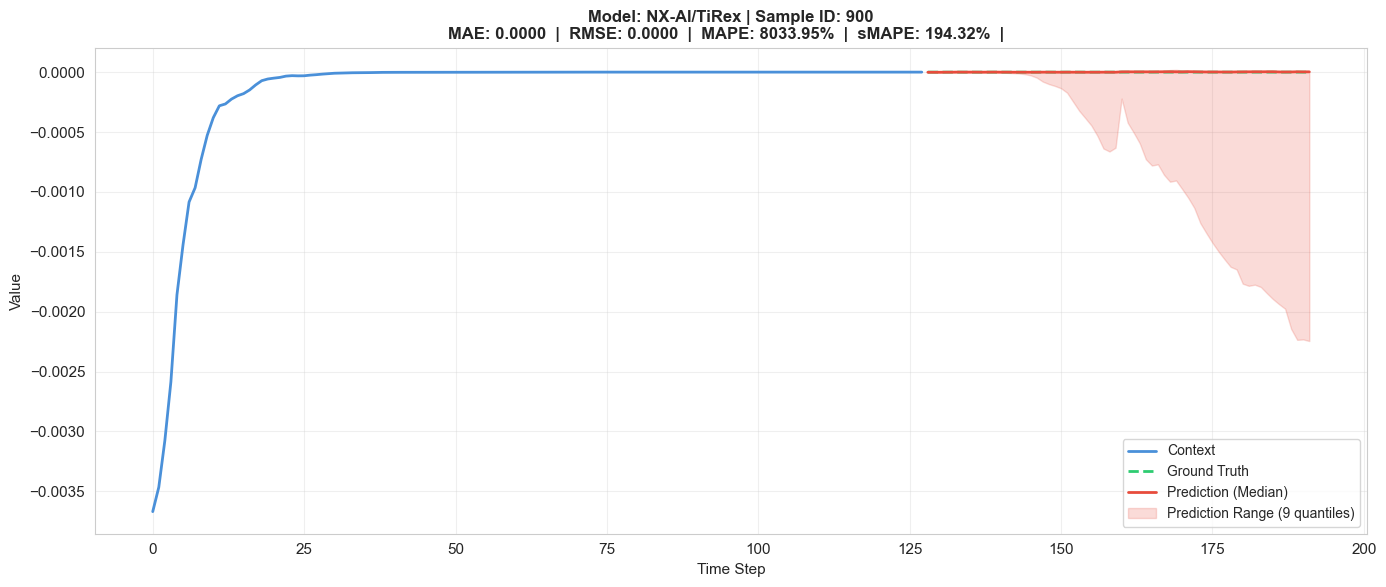

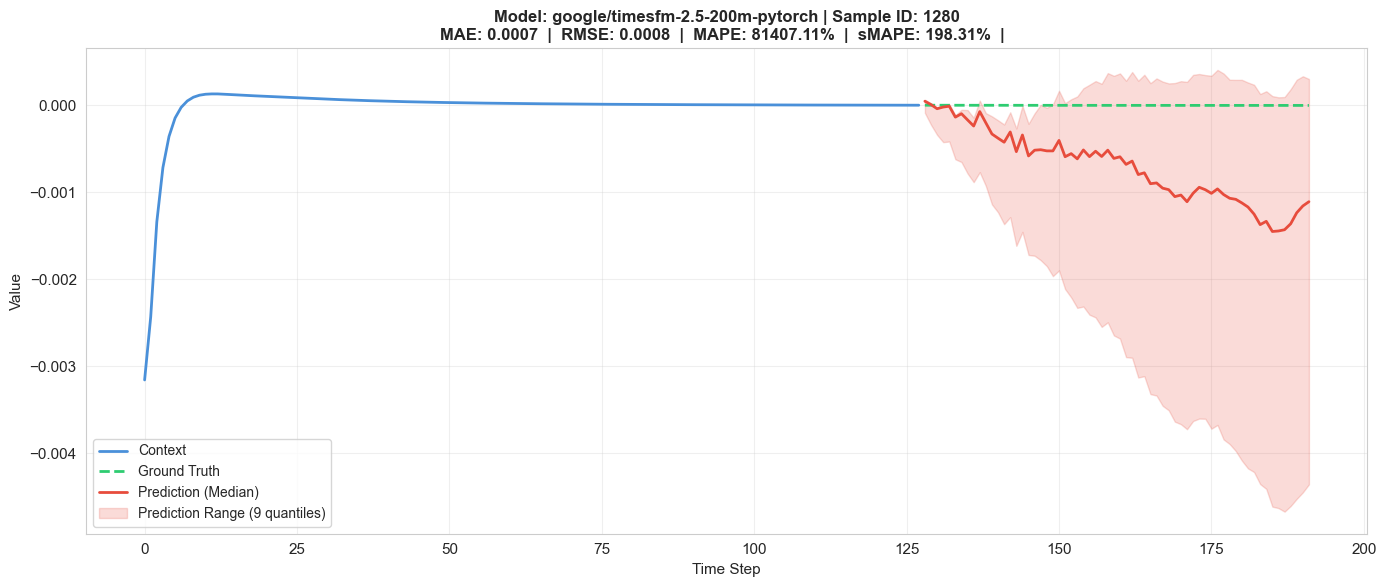

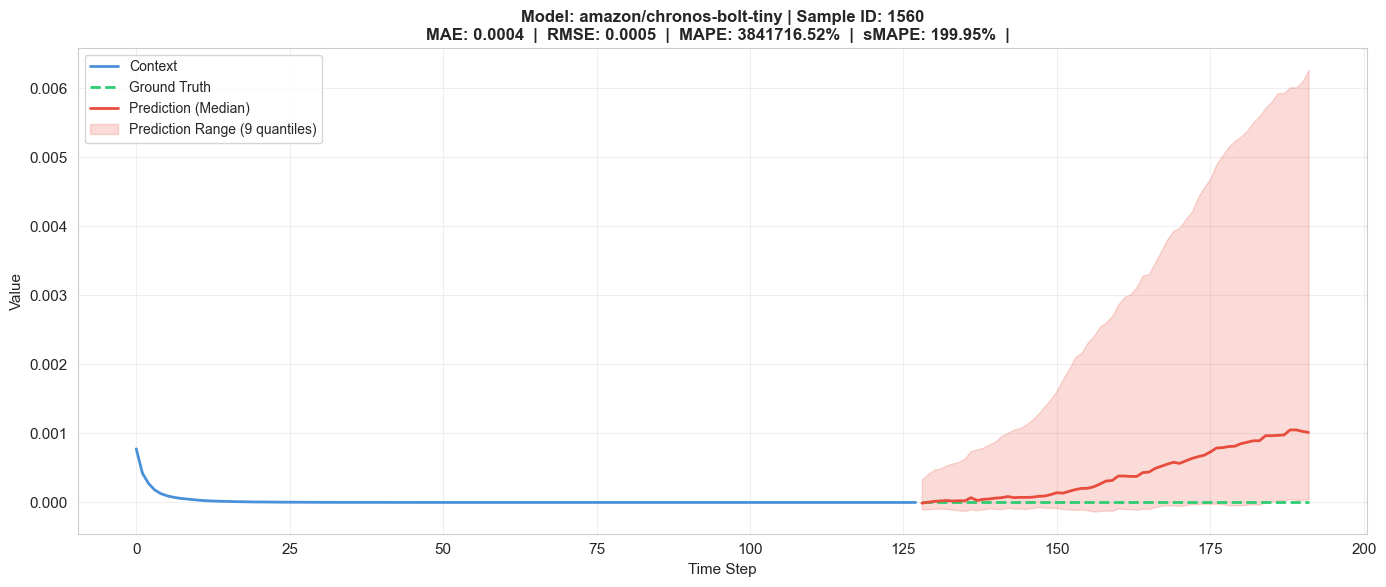

In [13]:
# Plot the worst prediction for each model
print("Plotting worst prediction for each model...\n")

for model in df['model'].unique():
    model_data = df[df['model'] == model]
    worst_sample = model_data.nlargest(1, 'sMAPE').iloc[0]
    
    plot_sample_prediction(worst_sample, show_quantiles=True)

## 9. Identify Best Predictions

In [14]:
# Find best predictions by MAE for each model
print("🟢 Best Predictions by MAE (Top 3 per model)\n")
print("=" * 80)

for model in df['model'].unique():
    model_data = df[df['model'] == model]
    best_samples = model_data.nsmallest(3, 'MAPE')
    
    print(f"\n{model}:")
    print("-" * 80)
    for idx, row in best_samples.iterrows():
        print(f"  Sample {row['sample_id']}: MAE={row['MAE']:.4f}, RMSE={row['RMSE']:.4f}, MAPE={row['MAPE']:.2f}%")

🟢 Best Predictions by MAE (Top 3 per model)


amazon/chronos-2:
--------------------------------------------------------------------------------
  Sample 538: MAE=0.0000, RMSE=0.0000, MAPE=0.00%
  Sample 539: MAE=0.0000, RMSE=0.0000, MAPE=0.00%
  Sample 594: MAE=0.0000, RMSE=0.0000, MAPE=0.00%

NX-AI/TiRex:
--------------------------------------------------------------------------------
  Sample 715: MAE=0.0000, RMSE=0.0000, MAPE=0.00%
  Sample 593: MAE=0.0000, RMSE=0.0000, MAPE=0.00%
  Sample 592: MAE=0.0000, RMSE=0.0000, MAPE=0.00%

google/timesfm-2.5-200m-pytorch:
--------------------------------------------------------------------------------
  Sample 538: MAE=0.0000, RMSE=0.0000, MAPE=0.00%
  Sample 539: MAE=0.0000, RMSE=0.0000, MAPE=0.00%
  Sample 594: MAE=0.0000, RMSE=0.0000, MAPE=0.00%

amazon/chronos-bolt-tiny:
--------------------------------------------------------------------------------
  Sample 716: MAE=0.0000, RMSE=0.0000, MAPE=0.00%
  Sample 715: MAE=0.0000, RMSE=0.0000

## 10. Compare Models on Same Sample

Comparing all models on Sample ID: 1560



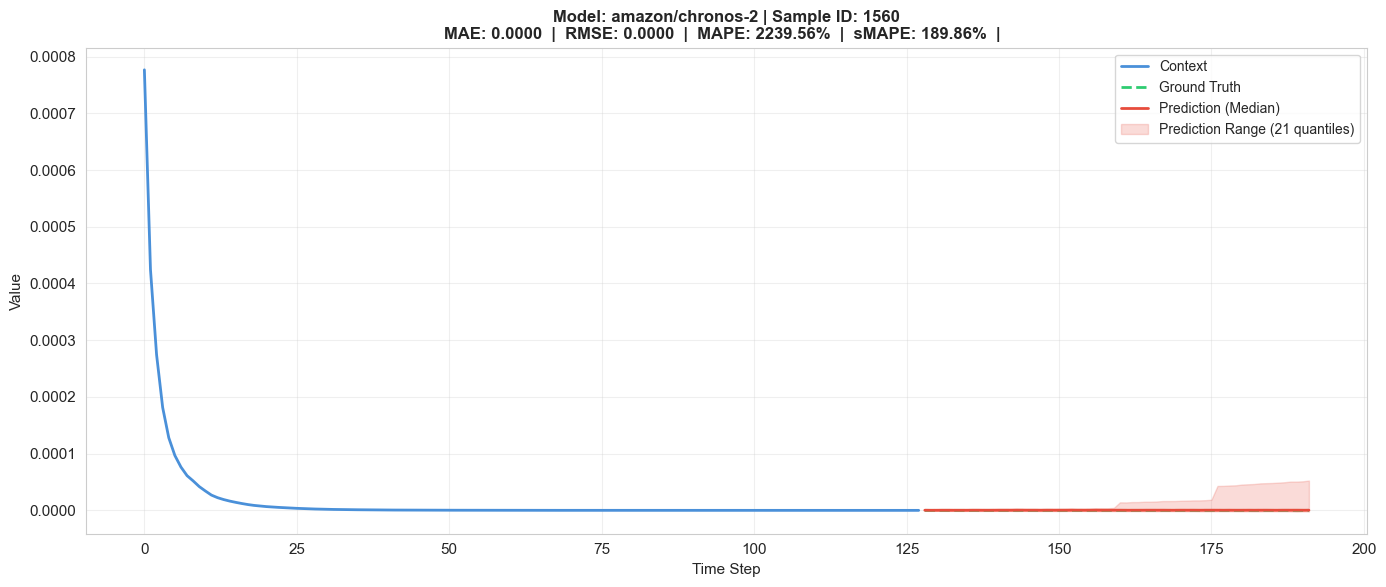

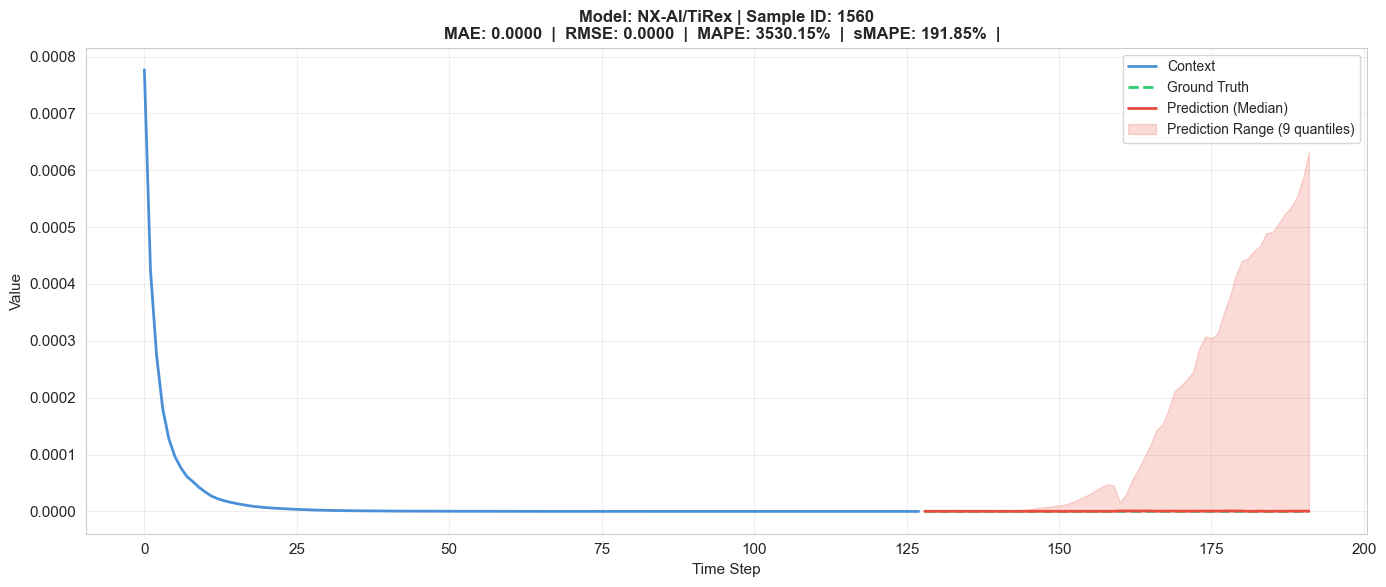

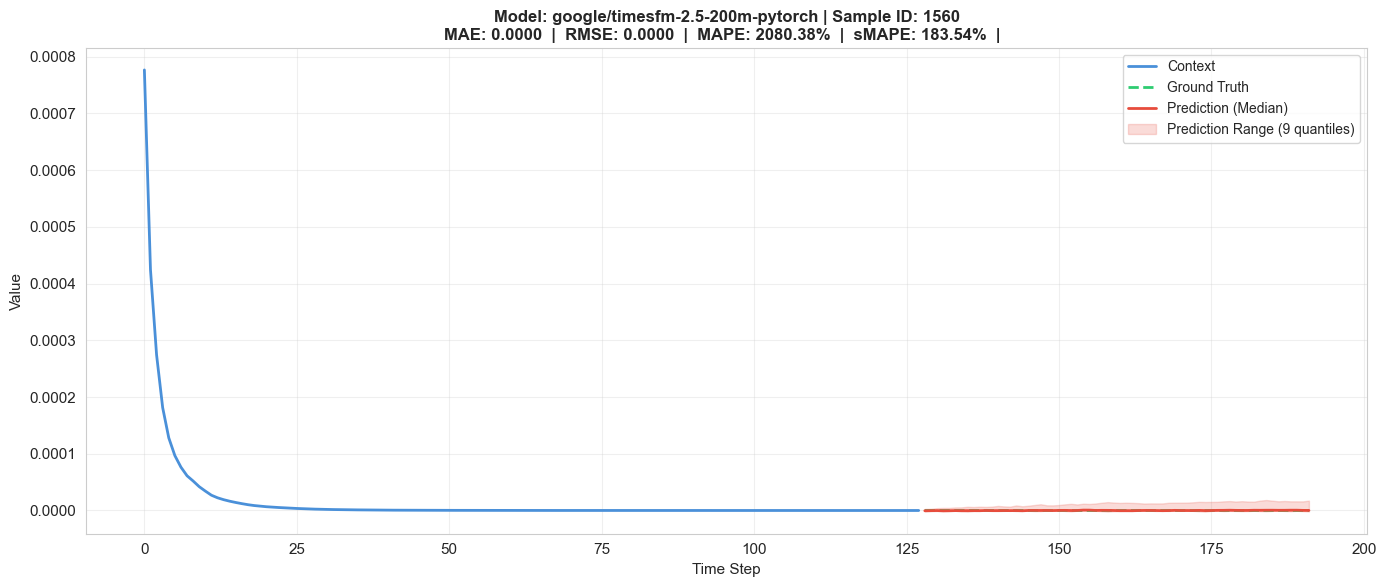

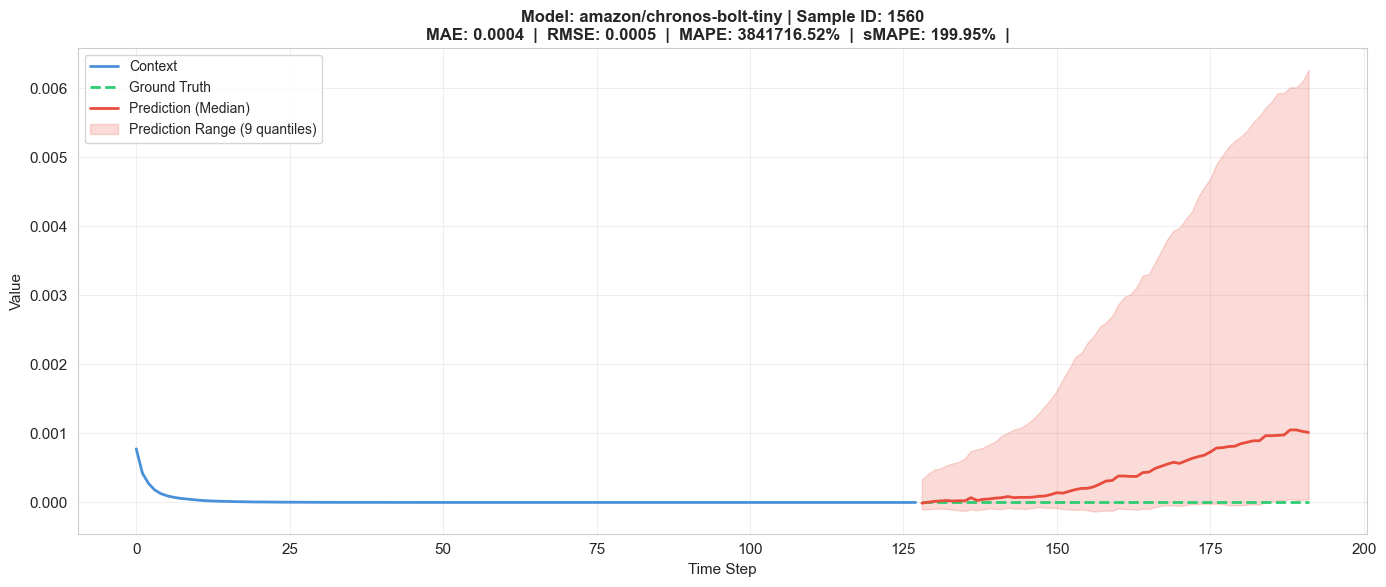

In [15]:
# Compare all models on a specific sample (e.g., sample_id=0)
sample_id_to_compare = 1560

print(f"Comparing all models on Sample ID: {sample_id_to_compare}\n")

for model in df['model'].unique():
    model_sample = df[(df['model'] == model) & (df['sample_id'] == sample_id_to_compare)]
    
    if not model_sample.empty:
        plot_sample_prediction(model_sample.iloc[0], show_quantiles=True)

## 11. Interactive Sample Explorer


💡 Use explore_sample(model_name, sample_id) to view specific predictions

Available models: ['amazon/chronos-2', 'NX-AI/TiRex', 'google/timesfm-2.5-200m-pytorch', 'amazon/chronos-bolt-tiny']
Sample ID range: 0 to 6019


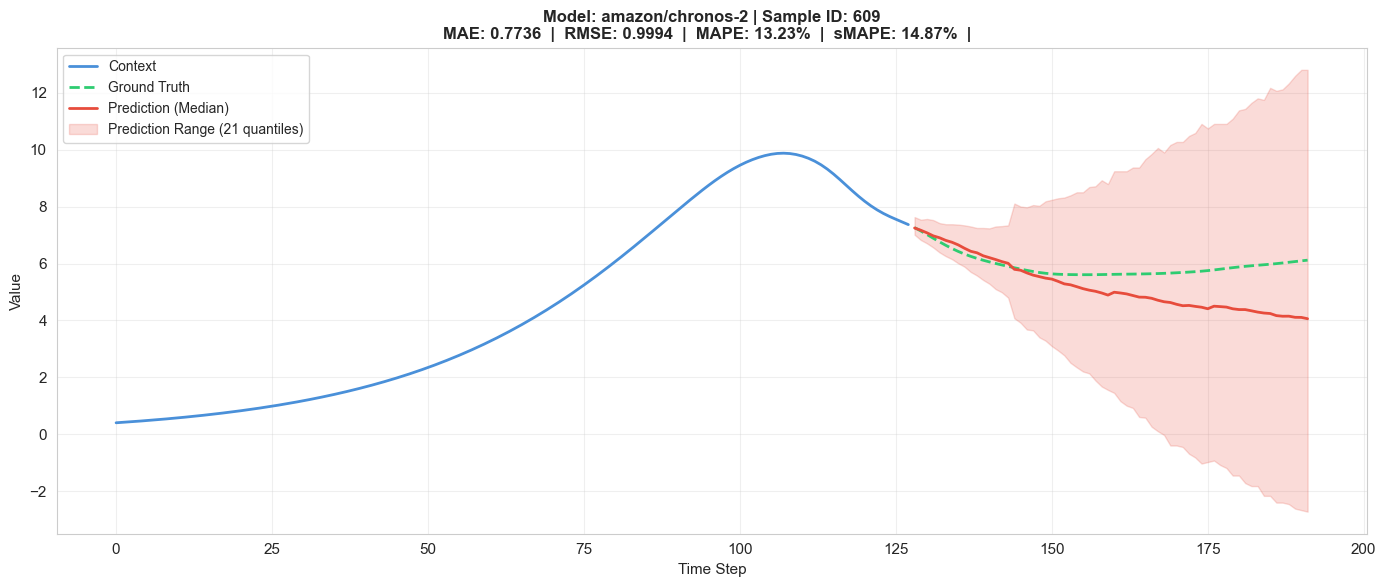

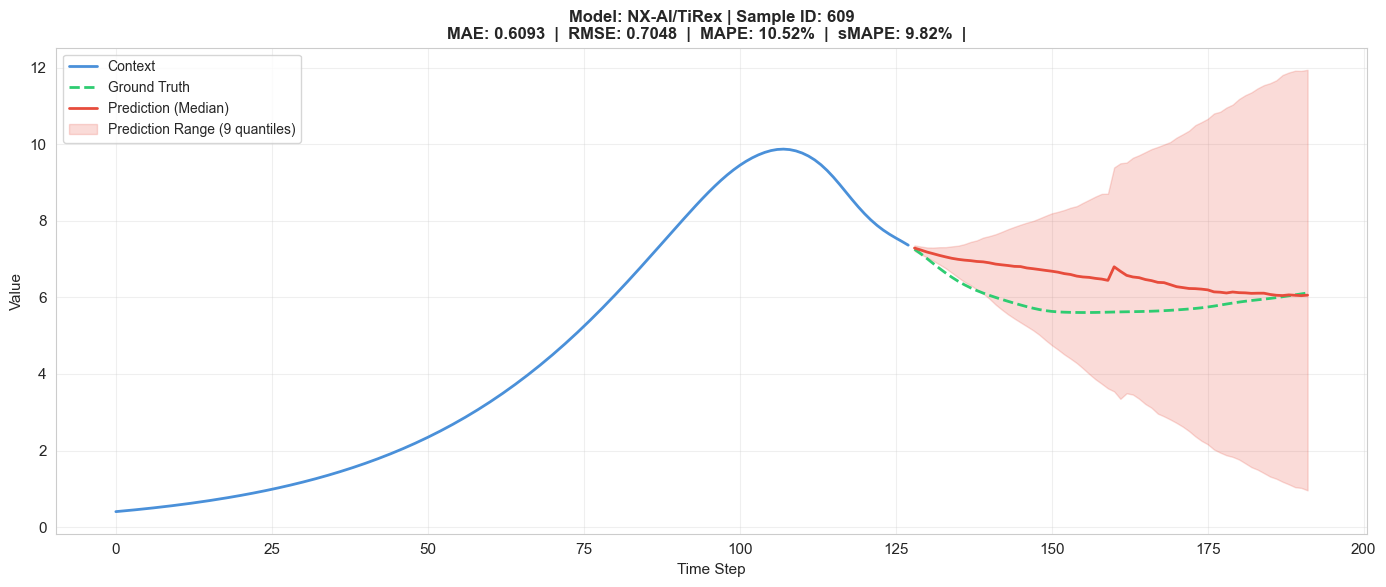

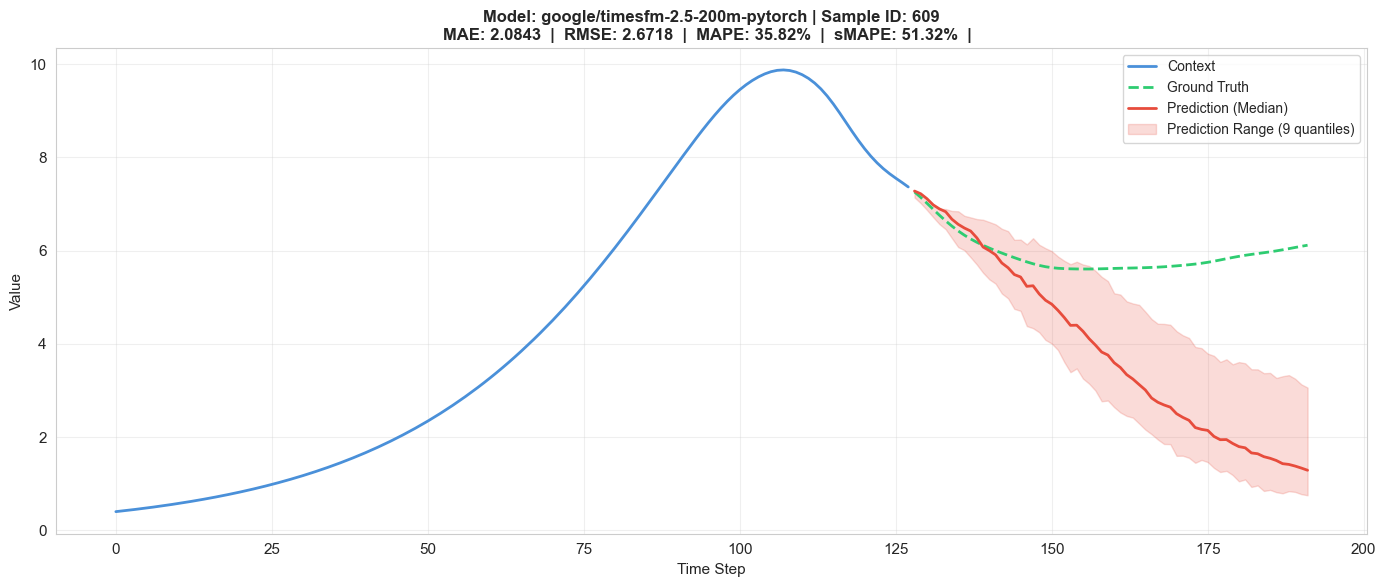

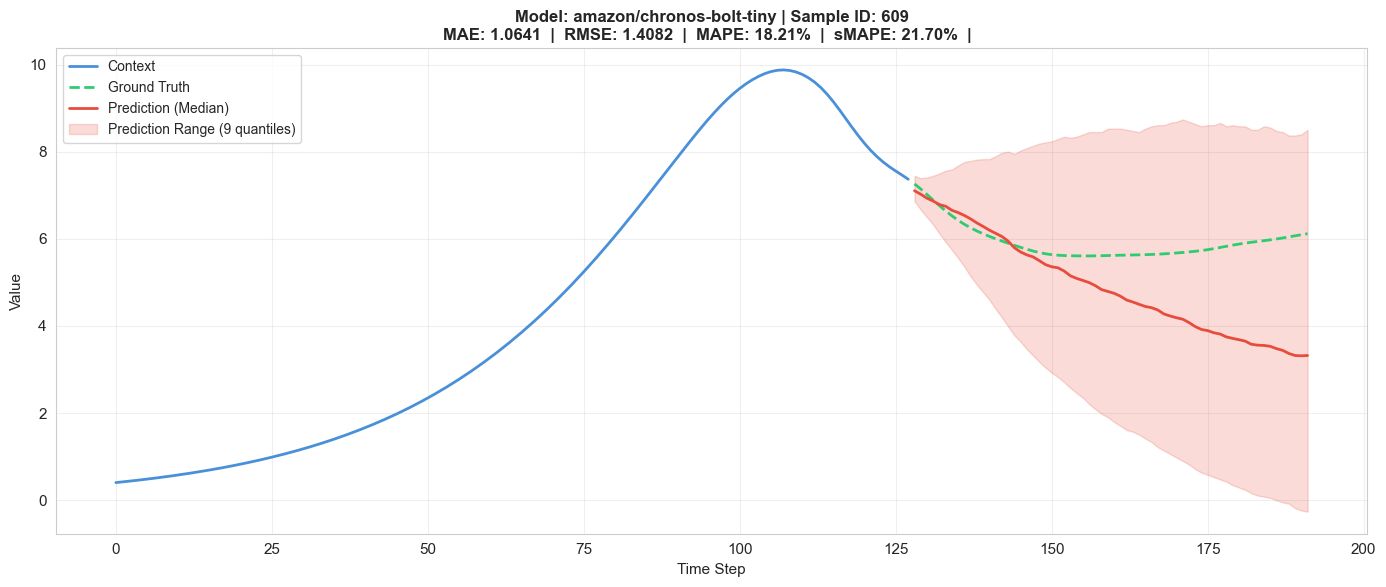

In [35]:
# Function to explore any sample by model and sample_id
def explore_sample(model_name: str, sample_id: int, show_quantiles: bool = True):
    """Plot a specific sample for a specific model."""
    sample_data = df[(df['model'] == model_name) & (df['sample_id'] == sample_id)]
    
    if sample_data.empty:
        print(f"❌ No data found for model '{model_name}' and sample_id {sample_id}")
        return
    
    plot_sample_prediction(sample_data.iloc[0], show_quantiles=show_quantiles)

# Example usage - change these values to explore different samples
print("\n💡 Use explore_sample(model_name, sample_id) to view specific predictions")
print(f"\nAvailable models: {df['model'].unique().tolist()}")
print(f"Sample ID range: 0 to {df['sample_id'].max()}")

# Uncomment and modify to explore:
idx = 609
explore_sample('amazon/chronos-2', idx)
explore_sample('NX-AI/TiRex', idx)
explore_sample('google/timesfm-2.5-200m-pytorch', idx)
explore_sample('amazon/chronos-bolt-tiny', idx)

## 12. Error Distribution Analysis

In [ ]:
# Plot error distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

error_metrics = ['MAE', 'RMSE', 'MAPE', 'Directional Accuracy']

for idx, metric in enumerate(error_metrics):
    ax = axes[idx]
    
    for model in df['model'].unique():
        model_data = df[df['model'] == model][metric].dropna()
        ax.hist(model_data, bins=30, alpha=0.5, label=model.split('/')[-1], edgecolor='black')
    
    ax.set_title(f'{metric} Distribution', fontsize=14, fontweight='bold')
    ax.set_xlabel(metric, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Error Distribution Comparison (V2 Benchmarks)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 13. Export Results

In [13]:
# Export summary to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_file = f"benchmarkv2_summary_{timestamp}.csv"

# Export metrics only (without timeseries data)
export_columns = ['model', 'sample_id', 'mean', 'std'] + metric_columns

df[export_columns].to_csv(summary_file, index=False)

print(f"✅ Summary exported to: {summary_file}")
print(f"\n📊 Final Model Rankings (by mean MAE):")
print(df.groupby('model')['MAE'].mean().sort_values())

✅ Summary exported to: benchmarkv2_summary_20251212_121300.csv

📊 Final Model Rankings (by mean MAE):
model
NX-AI/TiRex                        11.177976
amazon/chronos-2                   11.575940
google/timesfm-2.5-200m-pytorch    12.083631
Name: MAE, dtype: float64
